<a href="https://colab.research.google.com/github/Chthanh/Recommender-System/blob/main/Rule-based%20Collaborative%20Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Thuật toán dựa trên luật (quy tắc) (Rule-based RecSys)

Là thuật toán sử dụng luật kết hợp (association rule): `item tiền đề -> item kết luận` để đề xuất item cho user mục tiêu, với ý nghĩa nếu user mục tiêu thích `item tiền đề` thì có thể họ cũng thích `item kết luận`.

Bài toán được chia thành 2 giai đoạn:
1. Tạo các luật kết hợp
  - Sử dụng thuật toán Apriori để tính toán các itemset phổ biến
  - Tìm các luật kết hợp với độ tin cậy > độ tin cậy tối thiểu cho trước (min_conf)
2. Đề xuất item
  - Nếu item mà user u yêu thích nằm trong danh sách các item tiền đề, và item kết luận tương ứng chưa được user u đánh giá thì đề xuất item kết luận cho user u.


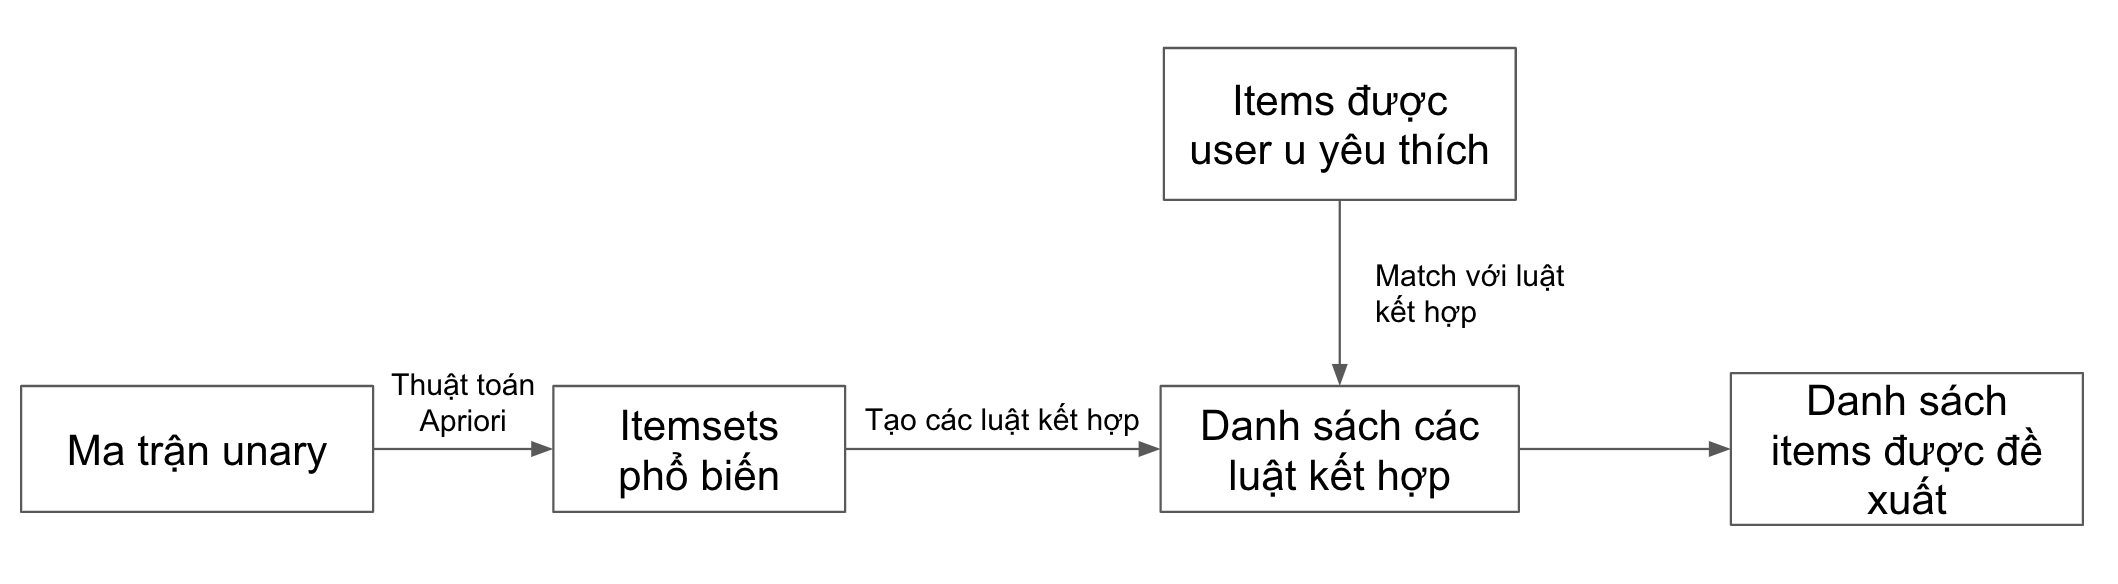

### 1. Tạo các luật kết hợp
#### 1.1. Thuật toán Apriori
Là một thuật toán cổ điển dùng cho phân tích mối quan hệ để tạo các các tập item phổ biến (frequent itemsets).

Quy trình:
- Bước 1: Tìm tất cả các tập phổ biến 1-hạng mục
  - Ví dụ: {Butter}, {Fish}, {Beef}, ...
- Bước 2: Kiểm tra độ phổ biến (support) của từng tập hạng mục, loại bỏ những tập hạng mục không phổ biến, ta được tập $L_i$.
  - Nếu supp$(X) = \frac{count(X)}{|D|} > $min_support thì X là tập phổ biến
- Bước 3: Tạo các tập $k$-hạng mục từ các tập phổ biến $(k-1)$-hạng mục phổ biến ở bước 2 và kiểm tra độ phổ biến của chúng.
  - Ví dụ: Nếu {Butter}, {Bread} và {Milk} là các 1-hạng mục phổ biến, thì tập 2-hạng mục như {Butter, Bread}, {Butter, Milk}, {Bread, Milk} sẽ được tạọ.
- Bước 4: Dừng khi không tạo được tập phổ biến, nghĩa là $L_k = \{\}$ hoặc $C_k = \{\}$

#### 1.2. Luật kết hợp

X => Y được gọi là luật kết hợp nếu hai điều kiện sau được thỏa mãn:
1. Độ phổ biến của X $\cup$ Y thấp nhất là min_support.
2. Độ tin cậy của X => Y ít nhất là min_conf.
$$\text{conf(X => Y)} = \frac{supp(X \cup Y)}{supp(X)} > \text{min_conf}$$


In [1]:
import numpy as np
import pandas as pd
from itertools import combinations, permutations

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Get all combinations of [1, 2, 3]
# and length 2
comb = combinations([1, 2, 3], 2)

# Print the obtained combinations
for i in list(comb):
    print (i)

(1, 2)
(1, 3)
(2, 3)


In [3]:
#An example of permutation, length=2
perm = permutations([1, 2, 3], 2)

# Print the obtained permutations
for i in list(perm):
    print (i)

(1, 2)
(1, 3)
(2, 1)
(2, 3)
(3, 1)
(3, 2)


In [4]:
# Ma trận ITEM-CUSTOMER
IC = np.array([[1, 1, 1, 0, 0, 0],
              [0, 1, 1, 0, 1, 0],
              [1, 1, 0, 0 ,0 ,0],
              [1, 1, 1, 1, 1, 1],
              [0, 0, 0, 1, 0, 1],
              [0, 0, 0, 1, 1, 1],
              [0, 1, 0, 1, 1, 0]])

df = pd.DataFrame(IC, index=['Jack', 'Mary', 'Jane', 'Sayani', 'John', 'Tom', 'Peter'],
                     columns = ['Bread', 'Butter', 'Milk', 'Fish', 'Beef', 'Ham'])

df

,Bread,Butter,Milk,Fish,Beef,Ham
Jack,1,1,1,0,0,0
Mary,0,1,1,0,1,0
Jane,1,1,0,0,0,0
Sayani,1,1,1,1,1,1
John,0,0,0,1,0,1
Tom,0,0,0,1,1,1
Peter,0,1,0,1,1,0


In [5]:
class AssociationRules():
  def __init__(self, unary_data=None, min_support=0.5, min_conf=0.5, max_length=4):
    """
      @params:
        inputdata: dataframe với dòng ~ user, cột ~ item
        min_support: độ phổ biến tối thiểu
        min_conf: độ tin cậy tối thiểu
        max_length: gom nhóm các item tối đa
    """
    self.data = unary_data # dataframe
    self.min_support = min_support
    self.min_conf = min_conf
    self.max_length = max_length
    self.freq_itemsets = {} # lưu các itemset phổ biến {'itemset':'support'}
    self.association_rules = [] #  lưu các luật kết hợp

  def apriori(self):
    """
    Hàm tính độ phổ biến danh sách các itemset phổ biến
    """

    # Khởi tạo L là danh sách gồm các item trong tập dataframe
    L = set(self.data.columns)

    for i in range(1, self.max_length+1):
      # c là danh sách các item trong L có thể kết hợp với nhau
      c = list(combinations(L,i))
      # reset L để lưu itemset phổ biến
      L = set()
      # lặp qua từng phần tử trong c
      for j in list(c):
        # tính độ phổ biến của phần tử j
        supp = self.data.loc[:,j].product(axis=1).sum()/self.data.shape[0]
        # nếu độ phổ biến của phần tử j > min_support thì lưu vào freq_itemsets
        if supp > self.min_support:
          self.freq_itemsets[j] = supp
          # Tập L gồm các itemset có độ phổ biến > min_support
          L = set(set(L) | set(j))

  def estimate_rules(self):
    # L là tập gồm các itemset phổ biến tìm được bởi thuật toán Apriori
    L = list(self.freq_itemsets.keys())
    # perm là danh sách gồm (itemset(X), itemset(X, Y)) được rút ra từ freq_itemsets
    perm = list(permutations(L, 2))
    # Chạy vòng lặp qua từng phần tử trong perm
    for i in perm:
      if (set(i[0]).issubset(i[1])):
        conf = self.freq_itemsets[i[1]]/self.freq_itemsets[i[0]] # tính độ tin cậy = supp(X union Y)/supp(X)
        # Nếu độ tin cậy > min_conf thì lưu vào kết quả
        if (conf > self.min_conf):
          j = i[1][not i[1].index(i[0][0])] # loại bỏ itemset(X) ra khỏi itemset(X, Y)
          self.association_rules.append([i[0], (j,), self.freq_itemsets[i[0]], self.freq_itemsets[(j,)], self.freq_itemsets[i[1]], conf])

  def learn_rules(self):
    self.apriori()
    self.estimate_rules()

    return (self.association_rules)


In [6]:
test = AssociationRules(df, min_support=0.4, min_conf=0.5, max_length=4)

association_rules = test.learn_rules()
pd.DataFrame(association_rules, columns=['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence']).sort_values('confidence', ascending=False)


,antecedents,consequents,antecedent support,consequent support,support,confidence
0,"(Ham,)","(Fish,)",0.428571,0.571429,0.428571,1.00
1,"(Milk,)","(Butter,)",0.428571,0.714286,0.428571,1.00
9,"(Bread,)","(Butter,)",0.428571,0.714286,0.428571,1.00
2,"(Beef,)","(Fish,)",0.571429,0.571429,0.428571,0.75
3,"(Beef,)","(Butter,)",0.571429,0.714286,0.428571,0.75
7,"(Fish,)","(Ham,)",0.571429,0.428571,0.428571,0.75
8,"(Fish,)","(Beef,)",0.571429,0.571429,0.428571,0.75
4,"(Butter,)","(Milk,)",0.714286,0.428571,0.428571,0.60
5,"(Butter,)","(Beef,)",0.714286,0.571429,0.428571,0.60
6,"(Butter,)","(Bread,)",0.714286,0.428571,0.428571,0.60


In [7]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [8]:
%cd /content/drive/MyDrive/Colab Notebooks/RecSys/week5

/content/drive/MyDrive/Colab Notebooks/RecSys/week5


In [9]:
# Load the dataset
data = pd.read_excel('data_01.xls')
data.rename(columns={"Unnamed: 0": "userId"}, inplace=True)
data.set_index('userId', inplace = True)
data.head()

,11: Star Wars: Episode IV - A New Hope (1977),12: Finding Nemo (2003),13: Forrest Gump (1994),14: American Beauty (1999),22: Pirates of the Caribbean: The Curse of the Black Pearl (2003),24: Kill Bill: Vol. 1 (2003),38: Eternal Sunshine of the Spotless Mind (2004),63: Twelve Monkeys (a.k.a. 12 Monkeys) (1995),77: Memento (2000),85: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),...,8467: Dumb & Dumber (1994),8587: The Lion King (1994),9331: Clear and Present Danger (1994),9741: Unbreakable (2000),9802: The Rock (1996),9806: The Incredibles (2004),10020: Beauty and the Beast (1991),36657: X-Men (2000),36658: X2: X-Men United (2003),36955: True Lies (1994)
userId,,,,,,,,,,,,,,,,,,,,,
1648,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,...,NaN,4.0,NaN,NaN,5.0,3.5,3.0,NaN,3.5,NaN
5136,4.5,5.0,5.0,4.0,5.0,5.0,5.0,3.0,NaN,5.0,...,1.0,5.0,NaN,NaN,NaN,5.0,5.0,4.5,4.0,NaN
918,5.0,5.0,4.5,NaN,3.0,NaN,5.0,NaN,5.0,NaN,...,NaN,5.0,NaN,NaN,NaN,3.5,NaN,NaN,NaN,NaN
2824,4.5,NaN,5.0,NaN,4.5,4.0,NaN,NaN,5.0,NaN,...,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3867,4.0,4.0,4.5,NaN,4.0,3.0,NaN,NaN,NaN,4.5,...,1.0,4.0,NaN,NaN,NaN,3.0,4.0,4.0,3.5,3.0


In [10]:
def generate_unary_df(UIdf):
  """Hàm chuyển đổi ma trận user-item thành ma trận unary (1: user thích item, 0: user không thích item)"""
  # Khởi tạo dataframe có index và cột giống dataframe ban đầu
  unary_df = pd.DataFrame(index=UIdf.index, columns=UIdf.columns)
  # Thay thế giá trị khuyết = 0, còn lại = 1
  unary_df = UIdf.applymap(lambda x: 0 if pd.isna(x) or x < 3 else 1)

  return unary_df

unary_df = generate_unary_df(data)
unary_df.head()

,11: Star Wars: Episode IV - A New Hope (1977),12: Finding Nemo (2003),13: Forrest Gump (1994),14: American Beauty (1999),22: Pirates of the Caribbean: The Curse of the Black Pearl (2003),24: Kill Bill: Vol. 1 (2003),38: Eternal Sunshine of the Spotless Mind (2004),63: Twelve Monkeys (a.k.a. 12 Monkeys) (1995),77: Memento (2000),85: Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),...,8467: Dumb & Dumber (1994),8587: The Lion King (1994),9331: Clear and Present Danger (1994),9741: Unbreakable (2000),9802: The Rock (1996),9806: The Incredibles (2004),10020: Beauty and the Beast (1991),36657: X-Men (2000),36658: X2: X-Men United (2003),36955: True Lies (1994)
userId,,,,,,,,,,,,,,,,,,,,,
1648,0,0,0,0,1,1,0,0,0,0,...,0,1,0,0,1,1,1,0,1,0
5136,1,1,1,1,1,1,1,1,0,1,...,0,1,0,0,0,1,1,1,1,0
918,1,1,1,0,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,0,0
2824,1,0,1,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3867,1,1,1,0,1,1,0,0,0,1,...,0,1,0,0,0,1,1,1,1,1


In [12]:
#### Tạo các luật kết hợp
rules = AssociationRules(unary_df, min_support=0.7, min_conf=0.7, max_length=3)

association_rules = rules.learn_rules()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)


display(pd.DataFrame(association_rules, columns=['antecedents', 'consequents', 'antecedent support', 'consequent support', 'support', 'confidence'])
                     .sort_values('confidence', ascending=False)
                     .tail(10))

,antecedents,consequents,antecedent support,consequent support,support,confidence
148,"(603: The Matrix (1999),)","(155: The Dark Knight (2008),)",0.96,0.88,0.72,0.75
150,"(603: The Matrix (1999),)","(13: Forrest Gump (1994),)",0.96,0.92,0.72,0.75
120,"(603: The Matrix (1999),)","(604: The Matrix Reloaded (2003),)",0.96,0.72,0.72,0.75
137,"(603: The Matrix (1999),)","(24: Kill Bill: Vol. 1 (2003),)",0.96,0.80,0.72,0.75
136,"(603: The Matrix (1999),)","(24: Kill Bill: Vol. 1 (2003),)",0.96,0.80,0.72,0.75
135,"(603: The Matrix (1999),)","(8587: The Lion King (1994),)",0.96,0.76,0.72,0.75
133,"(603: The Matrix (1999),)","(238: The Godfather (1972),)",0.96,0.76,0.72,0.75
128,"(603: The Matrix (1999),)","(862: Toy Story (1995),)",0.96,0.72,0.72,0.75
121,"(603: The Matrix (1999),)","(607: Men in Black (a.k.a. MIB) (1997),)",0.96,0.76,0.72,0.75
151,"(603: The Matrix (1999),)","(13: Forrest Gump (1994),)",0.96,0.92,0.72,0.75


In [29]:
class Recommender():

  def __init__(self, data=None, target_user=None, association_rules=None):
    self.data = data # ma trận rating
    self.target_user = target_user # user mục tiêu
    self.association_rules = association_rules # luật kết hợp được tính bằng thuật toán Apriori
    self.rated_items = [] # khởi tạo danh sách lưu các item target_user đã đánh giá
    self.unrated_items = [] # khởi tạo danh sách lưu các item target_user chưa đánh giá
    self.recommendations = [] # khởi tạo danh sách lưu các item sẽ được đề xuất cho target_user

  def get_itemList(self):
    """Hàm lưu các item yêu thích, item không thích và item chưa đánh giá của user mục tiêu"""
    # Các item mà target_user đã đánh giá
    rated_items = self.data[self.data.index==self.target_user].dropna(axis=1)
    # Các item mà target_user chưa đánh giá
    self.unrated_items = self.data.drop(columns=rated_items).columns
    self.rated_items = rated_items.columns

  def recommend_items(self):
    """Hàm lưu lại các item được đề xuất cho user mục tiêu"""

    # Lặp qua từng item được target_user đã đánh giá
    for item in self.rated_items:
      # Lặp qua từng luật trong luật kết hợp tìm được bằng thuật toán Apriori
      for rule in self.association_rules:
        antecedent, consequent, confidence = rule[0], rule[1], rule[5]
        # Nếu item tiền đề nằm trong danh sách được ưu thích và item kết luận chưa được đánh giá bởi target_user thì lưu lại item kết luận
        if (set(antecedent).issubset(self.rated_items)) & (consequent[0] in self.unrated_items):
          if (set(consequent) not in self.recommendations):
            self.recommendations.append(set(consequent))


  def learn_recs(self):
    """Hàm học hệ thống tư vấn"""
    self.get_itemList()
    self.recommend_items()

  def show_recs(self):
    """Hàm hiển thị kết quả"""
    print(f"Các phim đề xuất cho user {self.target_user}: \n")
    display(pd.DataFrame(self.recommendations, columns=['recommended items']))

In [30]:
### Đề xuất item cho user 89
target_user = 89
user_rec = Recommender(data, target_user, association_rules)

user_rec.learn_recs()

user_rec.show_recs()

Các phim đề xuất cho user 89: 



,recommended items
0,98: Gladiator (2000)
1,597: Titanic (1997)
2,8587: The Lion King (1994)
3,77: Memento (2000)
